In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_files
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import time
%matplotlib inline
#RNN libraries
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')


In [9]:
#settings seaborn plots
sns.set(style="whitegrid")

In [10]:
#data directory for train set
DATA_DIR = "C:/Users/javim/Repositories/ml_2020s_group32/ml_2020s_group32/exercise_3/data/20news-bydate-train"

#data directory for the test set
DATA_DIR_test = "C:/Users/javim/Repositories/ml_2020s_group32/ml_2020s_group32/exercise_3/data/20news-bydate-test"

In [11]:
# divides data into labels (target) and (data) 
data = load_files(DATA_DIR, encoding = "utf-8", decode_error = "replace")

#we do the same for test data
data_test = load_files(DATA_DIR_test, encoding = "utf-8", decode_error = "replace")

In [12]:
# removing \r, \n, \t quotes and useless spaces
for i in range(len(data.data)):
    for j in ["\r", "\n", "   ", "\t" "''", "\ " ]:
        data.data[i] = data.data[i].replace(j, " ")

#show first document after cleaning special characters
data.data[0]

"From: cubbie@garnet.berkeley.edu (           )  Subject: Re: Cubs behind Marlins? How?  Article-I.D.: agate.1pt592$f9a  Organization: University of California, Berkeley  Lines: 12  NNTP-Posting-Host: garnet.berkeley.edu  gajarsky@pilot.njin.net writes:  morgan and guzman will have era's 1 run higher than last year, and the cubs will be idiots and not pitch harkey as much as hibbard. castillo won't be good (i think he's a stud pitcher)     This season so far, Morgan and Guzman helped to lead the Cubs   at top in ERA, even better than THE rotation at Atlanta.   Cubs ERA at 0.056 while Braves at 0.059. We know it is early   in the season, we Cubs fans have learned how to enjoy the   short triumph while it is still there.  "

In [13]:
# removing \r, \n, \t quotes and useless spaces
for i in range(len(data_test.data)):
    for j in ["\r", "\n", "   ", "\t" "''", "\ " ]:
        data_test.data[i] = data_test.data[i].replace(j, " ")

In [14]:
#downcase
for i in range(len(data.data)):
    data.data[i] = data.data[i].lower()
for i in range(len(data_test.data)):
    data_test.data[i] = data_test.data[i].lower()

In [15]:
# removing punctuation signs
for i in range(len(data.data)):
    for j in ["?", ".", "(", ")", ":", ";", "#", ",", "!", "'s", "'t", ">", "|", "]", "[", "-", "=", "@", "email", "mail", "uk", "usa", "00"]: #remove also possesive pronouns terminations and other words we realized we don't need
        data.data[i] = data.data[i].replace(j, " ")
for i in range(len(data_test.data)):
    for j in ["?", ".", "(", ")", ":", ";", "#", ",", "!", "'s", "'t", ">", "|", "]", "[", "-", "=", "@", "email", "mail", "uk", "usa", "00"]: #remove also possesive pronouns terminations and other words we realized we don't need
        data_test.data[i] = data_test.data[i].replace(j, " ")

In [16]:
#let's put everything a classical data frame for better manipulation in the text representation and modelling
df = pd.DataFrame(data.target, columns=["target"])

#add content
df["content"] = data.data

#let's put everything a classical data frame for better manipulation in the text representation and modelling
df_test = pd.DataFrame(data_test.target, columns=["target"])

#add content
df_test["content"] = data_test.data

In [17]:
# Let's also separate the labels from the X
X_train = df["content"]
y_train = df["target"]

# test data
X_test = df_test["content"]
y_test = df_test["target"]

In [18]:
# Parameter election
ngram_range = (1,1) #use only unigrams
min_df = 10
max_df = 1.
max_features = 300
stop_words = "english"

In [19]:
#built the vectorizer
tfidf = TfidfVectorizer(
    encoding='utf-8',
    ngram_range=ngram_range,
    stop_words=stop_words,
    lowercase=False,
    max_df=max_df,
    min_df=min_df,
    max_features=max_features,
    norm='l2',
    sublinear_tf=True
)

#transform 
X_train = tfidf.fit_transform(X_train)

#only transform
X_test = tfidf.transform(X_test)

In [20]:
#define a dictionary that matches each category to 
category_codes = {
 'alt.atheism' : 0,
 'comp.graphics' : 1,
 'comp.os.ms-windows.misc' : 2 ,
 'comp.sys.ibm.pc.hardware' :3 ,
 'comp.sys.mac.hardware' : 4,
 'comp.windows.x' : 5,
 'misc.forsale' : 6,
 'rec.autos' : 7,
 'rec.motorcycles' : 8,
 'rec.sport.baseball' : 9,
 'rec.sport.hockey' : 10,
 'sci.crypt' : 11,
 'sci.electronics' : 12,
 'sci.med' : 13,
 'sci.space' : 14,
 'soc.religion.christian' : 15,
 'talk.politics.guns' : 16,
 'talk.politics.mideast' : 17,
 'talk.politics.misc' : 18,
 'talk.religion.misc' : 19
}

In [21]:
#show
df

target                                            content
0           9  from  cubbie garnet berkeley edu              ...
1           4  from  gnelson pion rutgers edu  gregory nelson...
2          11  from  crypt comments math ncsu edu  subject  c...
3           4  from       subject  re  quadra scsi problems  ...
4           0  from  keith cco caltech edu  keith allan schne...
...       ...                                                ...
11309       8  from  rbemben timewarp prime com  rich bemben ...
11310       5  from  stevedav netcom com  steve davidson   su...
11311      16  from   05111312 mci  com  peter nesbitt   subj...
11312      18  from  eck panix com  mark eckenwiler   subject...
11313       4  from  lau aerospace aero org  david lau   subj...

[11314 rows x 2 columns]

In [22]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 300
# Max number of words in each sequence (mean of each text length).
MAX_SEQUENCE_LENGTH = 2000
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['content'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 138592 unique tokens.


In [23]:
X = tokenizer.texts_to_sequences(df['content'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (11314, 2000)


In [25]:
Y = pd.get_dummies(df['target']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (11314, 20)


In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(10182, 2000) (10182, 20)
(1132, 2000) (1132, 20)


In [27]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(20, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Train on 9163 samples, validate on 1019 samples
Epoch 1/5
9163/9163 [==============================] - 1311s 143ms/step - loss: 2.8890 - accuracy: 0.0901 - val_loss: 2.7760 - val_accuracy: 0.1237
Epoch 2/5
9163/9163 [==============================] - 1272s 139ms/step - loss: 2.7091 - accuracy: 0.1456 - val_loss: 2.6230 - val_accuracy: 0.1609
Epoch 3/5
9163/9163 [==============================] - 1290s 141ms/step - loss: 2.5452 - accuracy: 0.1895 - val_loss: 2.4577 - val_accuracy: 0.2149
Epoch 4/5
9163/9163 [==============================] - 1239s 135ms/step - loss: 2.4517 - accuracy: 0.2237 - val_loss: 2.3983 - val_accuracy: 0.2434
Epoch 5/5
9163/9163 [==============================] - 1259s 137ms/step - loss: 2.3563 - accuracy: 0.2507 - val_loss: 2.3356 - val_accuracy: 0.2601


In [28]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 9163 samples, validate on 1019 samples
Epoch 1/5
9163/9163 [==============================] - 1354s 148ms/step - loss: 2.3808 - accuracy: 0.2574 - val_loss: 2.3309 - val_accuracy: 0.2699
Epoch 2/5
9163/9163 [==============================] - 1361s 148ms/step - loss: 2.2932 - accuracy: 0.2865 - val_loss: 2.3459 - val_accuracy: 0.2542
Epoch 3/5
9163/9163 [==============================] - 1351s 147ms/step - loss: 2.2257 - accuracy: 0.2979 - val_loss: 2.2795 - val_accuracy: 0.2846
Epoch 4/5
9163/9163 [==============================] - 1353s 148ms/step - loss: 2.1553 - accuracy: 0.3245 - val_loss: 2.2422 - val_accuracy: 0.2895
Epoch 5/5
9163/9163 [==============================] - 5876s 641ms/step - loss: 2.1403 - accuracy: 0.3301 - val_loss: 2.2003 - val_accuracy: 0.3013


In [29]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1132/1132 [==============================] - 20s 17ms/step
Test set
  Loss: 2.184
  Accuracy: 0.317


Text(0.5, 1.0, 'Loss')

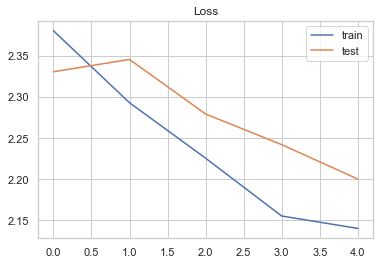

In [30]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [33]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Accuracy')

KeyError: 'acc'

In [ ]:
#new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
#seq = tokenizer.texts_to_sequences(new_complaint)
#padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
#pred = model.predict(padded)
#labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
#print(pred, labels[np.argmax(pred)])